In [69]:
from PIL import Image
from numpy import *
from pylab import *
import imregistration
imregistration = reload(imregistration)
import imtools
import os
from scipy import ndimage
from scipy.misc import imsave
import os

In [102]:
def read_points_from_pts(dir):
    files = imtools.get_imlist(dir)
    faces = {}
    for path in files:
        fileName = os.path.basename(path)
        base = os.path.splitext(path)[0]
        txtfile = base + ".pts"
        f = open(txtfile, 'r')
        for i in range(3+68):
            line = f.readline()
            if (i==3+37):
                p1 = line.split()
            elif (i==3+46):
                p2 = line.split()
            elif (i==3+58):
                p3 = line.split()
        xf = int(float(p1[0]))
        yf = int(float(p1[1]))
        xs = int(float(p2[0]))
        ys = int(float(p2[1]))
        xm = int(float(p3[0]))
        ym = int(float(p3[1]))
        faces[fileName]=array([xf, yf, xs, ys, xm, ym])
    return faces

In [134]:
def rigid_alignment1(faces,path,plotflag=False):
    """ Align images rigidly and save as new images.
    path determines where the aligned images are saved.
    set plotflag=True to plot the images. """
    
    refpoints = faces.values()[0]
    wm = 2000
    hm = 2000
    
    import math
    
    for face in faces:
        points = faces[face]
        
        #print "refpoints: ", refpoints, "\n"
        #print "points:    ", points, "\n"

        R,tx,ty = imregistration.compute_rigid_transform(refpoints,points)
        #print "R: ", R, "\n"
        #print "(tx, ty): ", (tx, ty), "\n"
        
        ## Scale is not in the text book but needed
        s = math.sqrt(R[0][0]**2+R[0][1]**2)
        #print "Scale: ", s, "\n"
        
        T = array([[R[1][1], R[1][0]], [R[0][1], R[0][0]]])

        im = array(Image.open(os.path.join(path,face)))
        im1 = zeros([wm, hm, 3])
        m, n, c = im.shape
        m = min(wm, m)
        n = min(hm, n)
        c = min(3, c)
        im1[0:m, 0:n, 0:c] = im[0:m, 0:n, 0:c]
        im2 = zeros(im1.shape, 'uint8')

        # Per color channel
        for i in range(len(im.shape)):
            im2[:, :, i] = ndimage.affine_transform(im1[:,:,i],linalg.inv(T),
                                                    offset=[-ty/s,-tx/s])
            # need to normalize the trainsition with scale
        if plotflag:
            imshow(im2)
            show()

        im2 = uint8(im2)
        h,w = im2.shape[:2]
        outsize = 1024
        border = 128
        imsave(os.path.join(path, 'aligned/'+face),
               im2[border:outsize+border,border:outsize+border,:])


In [135]:
points = read_points_from_pts('../faces/trainset/')
rigid_alignment1(points, '../faces/trainset/')

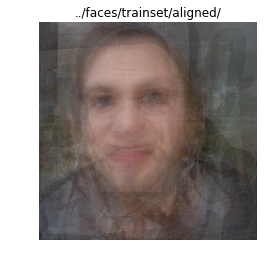

In [138]:
from pylab import *
import imtools

dir = '../faces/trainset/aligned/'
imlist = imtools.get_imlist(dir)
avgimg = imtools.compute_average(sorted(imlist))
figure()
imshow(avgimg)
gray()
axis('off')
title(dir)

show()

In [139]:
from PIL import Image, ImageDraw
import pca

pca.py:24: RuntimeWarning: invalid value encountered in sqrt
  S = sqrt(e)[::-1] # 固有値の並びも反転する


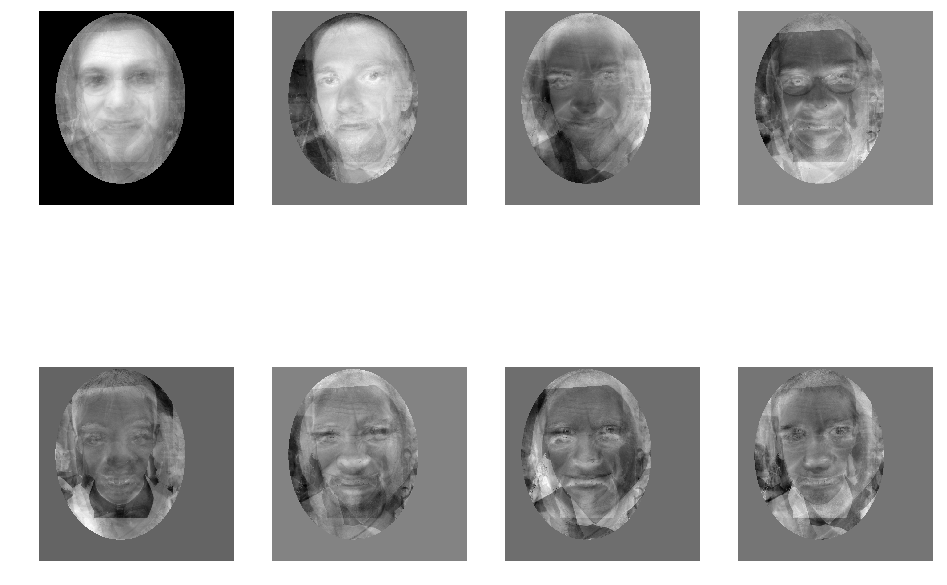

In [143]:
imlist = imtools.get_imlist('../faces/trainset/aligned/')
imlist = sorted(imlist)

im = array(Image.open(imlist[0]).convert('L'))
m, n = im.shape[0:2]
imnbr = len(imlist)

maskim = Image.new('L', (n,m))
draw = ImageDraw.Draw(maskim)
draw.ellipse((86,16,768,912),fill=1)
mask=array(maskim).flatten()

immatrix = array([mask*array(Image.open(imlist[i]).convert('L')).flatten() for i in range(15)], 'f')

V, S, immean = pca.pca(immatrix)

figure(figsize=(16, 12))
gray()
subplot(2, 4, 1)
imshow(immean.reshape(m,n))
axis('off')
for i in range(7):
    subplot(2, 4, i+2)
    imshow(V[i].reshape(m,n))
    axis('off')
    
show()